これはjupyter notebook( https://jupyter.org/ )です。  

networkxについてはここを参照。  
https://networkx.github.io/documentation/networkx-2.0/index.html  


## 基本的なネットワークモデル

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections

まず前提として、ネットワークをグラフ理論としてのグラフとして考える。  
ここでいうグラフとは点と線の集合として定義されるのものである。  
グラフ$G=(V,E)$、$V$は点の集合、$E$は線の集合。  
点はノードもしくはVertex、線はエッジ(Edge)もしくはリンク(Link)という。  
以降、言及しない場合はエッジは向きがなく、重みがないものとする。(Undirected, Unweight)  
  
例として下のコラムに図示する。

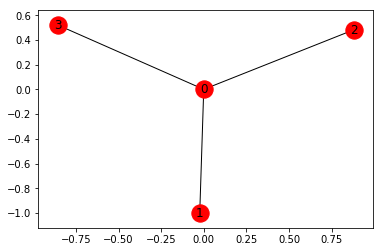

In [7]:
G=nx.Graph()
G.add_edges_from([[0,1],[0,2],[0,3]])
nx.draw_networkx(G)

 また、ノードにつながっているエッジの本数を次数(degree)という。次数は$k$でよく示される。   
上のグラフであれば1,2,3の点(ノード)の次数が1、0の点の次数が3となる。  
  
次数の分布を次数分布(degree distribution)として考える。  
上のグラフであれば次数1のものが3個、次数3のものが1個である。

## 1. Barabasi Albert model 
BA modelは次数分布がpower lawに従うモデルである。  
$$
P(k)=k^{-\gamma}
$$


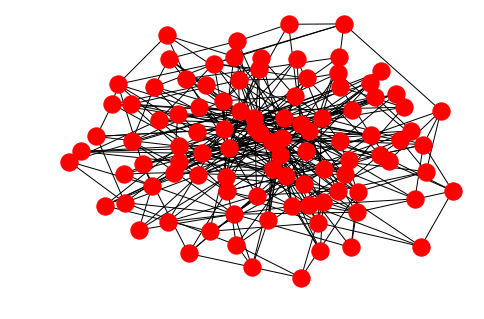

In [8]:
# BA model 
G=nx.generators.random_graphs.barabasi_albert_graph(100,4) #node_size 100, attach-edges 4
nx.draw_spring(G)

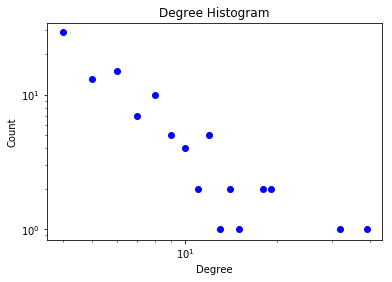

In [48]:
# Sampleコードを引用したもの、次数分布を示す(log-log)

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.scatter(deg, cnt, color='b')
#plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

上の図よりScale Freeとなっていることが分かる

## 2. Watts-Strogatz model 
WS modelはスモールワールド性が現れるネットワークモデルである。

平均経路長 12.878787878787879
平均クラスター係数 0.5
確率 0.0


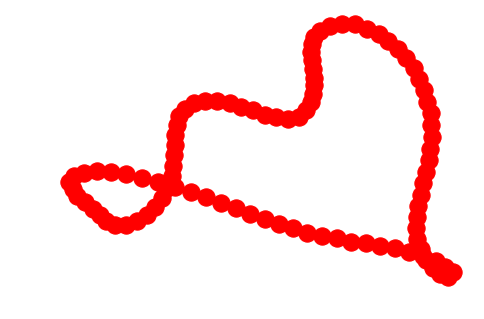

In [12]:
%matplotlib inline
n=100 # node size
k=4 # each node connects k nearest neigbors

p=0.0 
G=nx.connected_watts_strogatz_graph(n,k,p) # WS modelを生成
av_c=nx.algorithms.cluster.average_clustering(G) #平均クラスター係数を計算
av_l=nx.algorithms.average_shortest_path_length(G) #平均経路長を計算
print("平均経路長",av_l)
print("平均クラスター係数",av_c)
print("確率",p)

nx.draw_spring(G)

平均経路長 3.586060606060606
平均クラスター係数 0.08285714285714285
確率 0.5


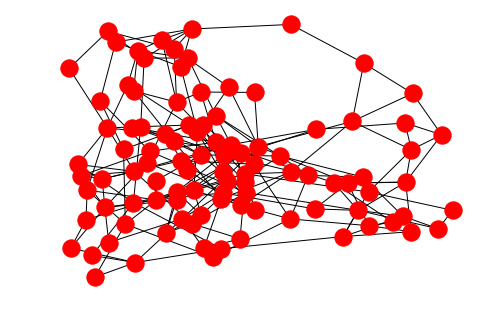

In [13]:
# P値を変更することによるグラフ構造の変化
p=0.5
G=nx.connected_watts_strogatz_graph(n,k,p)
av_c=nx.algorithms.cluster.average_clustering(G)
av_l=nx.algorithms.average_shortest_path_length(G)
print("平均経路長",av_l)
print("平均クラスター係数",av_c)
print("確率",p)

nx.draw_spring(G)

In [14]:

# n,k,pの Watts-Strogatz modelを作って平均クラスター係数と平均経路張を出力する関数
def WS_CL(n,k,p):
    G=nx.connected_watts_strogatz_graph(n,k,p)
    av_c=nx.algorithms.cluster.average_clustering(G)
    av_l=nx.algorithms.average_shortest_path_length(G)
    return av_c,av_l

# Pを適当な間隔で変更し、結果を配列にいれる
def make_WS_CL(n,k):
    clust=np.array([])
    leng=np.array([])
    prob=np.array([])
    p=0.0
    while(p<=1):
        C,L=WS_CL(n,k,p)
        if(p==0):
            C0=C
            L0=L
            p=0.00001
            #print(0,L0,C0)
        else:
            # 配列に入れる
            clust=np.append(clust,C/C0)
            leng=np.append(leng,L/L0)
            prob=np.append(prob,p)
            # pを適当な幅で更新
            if(p<0.0001):
                p+=0.00001
            elif(p<0.001):
                p=p+0.0001
            elif(p<0.01):
                p=p+0.001
            elif(p<0.1):
                p=p+0.01
            else:
                p+=0.1
            #
    return prob,clust,leng

# loop回平均を行う
loop=10
n=100
k=10
for j in range(loop):
    a,b,c=make_WS_CL(n,k)
    if(j==0):
        P=a.copy()
        C=b.copy()
        L=c.copy()
    else:
        for i in range(len(a)):
            P[i]+=a[i]
            C[i]+=b[i]
            L[i]+=c[i]
for i in range(len(P)):
    P[i]/=loop
    C[i]/=loop
    L[i]/=loop


クラスター係数$C$と平均経路長$L$が張り替え確率$p$でどのように変化するのかを示す。  
もともとのグラフを$p=0$のものとして基準とする。  

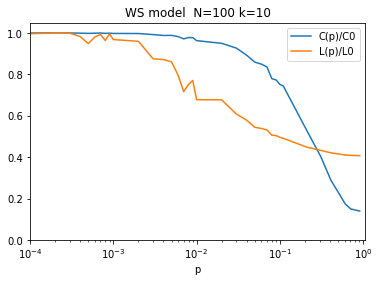

In [15]:
# C(p)/C(0)とL(p)/L(0)を図示

plt.title("WS model  N="+str(n)+" k="+str(k))
plt.xlabel("p")
plt.ylim([0,1.05])
plt.xlim([10**-4,1.05])
plt.xscale('log')
plt.plot(P,C,label="C(p)/C0")
plt.plot(P,L,label="L(p)/L0")
plt.legend()
plt.show()

## 3. Treeの直径
グラフ中の二点で最大頂点距離のものを直径という。  

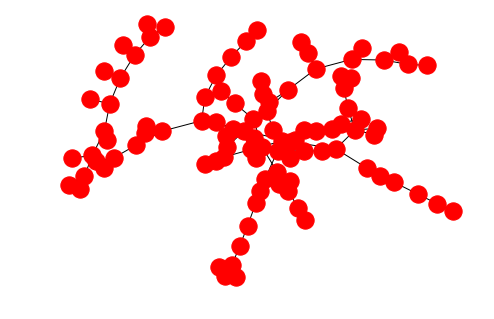

In [16]:
n=100
G=nx.trees.random_tree(n)
nx.draw_spring(G)

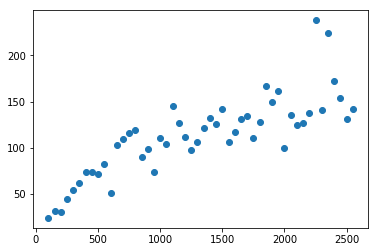

In [30]:
tree_d=np.array([])
xxx=np.array([])
av_loop=1
for i in range(50):
    n=i*50+100
    d=0
    for k in range(av_loop):
        G=nx.trees.random_tree(n)
        d+=nx.algorithms.distance_measures.diameter(G)
    d/=av_loop
    tree_d=np.append(tree_d,[d])
    xxx=np.append(xxx,[n])
#plt.yscale('log')
plt.scatter(xxx,tree_d)
plt.show()

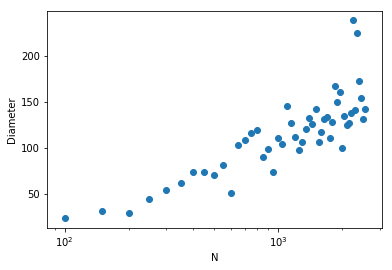

In [32]:
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("N")
plt.ylabel("Diameter")
plt.scatter(xxx,tree_d)
plt.show()

log(N)になってる...???  
もっとNを大きくする必要があるかも？